In [3]:
import pandas as  pd 
import numpy as np 
import tensorflow as tf
import tensorflow_datasets as tfds
import os 
from sklearn.model_selection import train_test_split
import zipfile

In [63]:
import matplotlib.pyplot as plt


In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # change it to "0" if yo have only one gpu or the gpu numbe  that you would like to use 

### Data processing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Extracting the data from the zip file
local_zip = '/content/drive/My Drive/Zindi/UmojaHackTunisia.zip'
password = 'kwpcb'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/',pwd=bytes(password,'utf-8'))
zip_ref.close()

In [6]:
def write_to_txt(file_name,column):
    with open(file_name, 'w') as f:
        for item in column:
            f.write("%s\n" % item)

In [19]:
train=pd.read_csv("/content/UmojaHackTun/train.csv")
test=pd.read_csv("/content/UmojaHackTun/test.csv")

In [8]:
train.head()

,ID,Sequence,target
0,ID_train_0,MVDGVMILPVLVMIAFPFPSMEDEKPKVNPKLYMCVCEGLSCGDEA...,0
1,ID_train_1,MAQKENAYPWPYGSKTSQSGLNTLSQRVLRKEPATTSALALVNRFN...,1
2,ID_train_2,MRLWPRSLFGRLVLILVSGMLAAQILTSSIWYDVRHSQVLEIPTRL...,2
3,ID_train_3,MNSIVKIMKMKQITYKLFMTTSLILLSFAVLIYLTLYFFLPTFYEQ...,2
4,ID_train_4,MKLIYQNVLSFLLIIVTTISIIGYSEIGYARNQAYTQNYQRMESYA...,2


In [1]:
max_seq_length=550# max seq length in this data set is 550 

In [2]:
# split data to train and validation 
train,val=train_test_split(train,test_size=0.1,random_state=42)

#reduce seq length
if max_seq_length>550 : 
    train["Sequence"]=train["Sequence"].apply(lambda x: "".join(list(x)[0:max_seq_length]))
    val["Sequence"]=val["Sequence"].apply(lambda x: "".join(list(x)[0:max_seq_length]))
    test["Sequence"]=test["Sequence"].apply(lambda x: "".join(list(x)[0:max_seq_length]))

NameError: ignored

In [11]:
# # write Sequnce column to txt file 
write_to_txt("/content/train.txt",train.Sequence)
write_to_txt("/content/test.txt",test.Sequence)
write_to_txt("/content/val.txt",val.Sequence)

In [12]:
train_label=train[["target"]].copy()
val_label=val[["target"]].copy()
train_label.to_csv("/content/train_label.csv",index=False)
val_label.to_csv("/content/val_label.csv",index=False)

### Data loaders 

In [4]:
train_label=pd.read_csv("/content/train_label.csv")
val_label=pd.read_csv("/content/val_label.csv")

In [5]:
train_batch_size=512
val_batch_size=512
number_of_class=train_label.target.nunique()
train_steps = len(train_label) // train_batch_size + int(len(train_label) % train_batch_size > 0)
val_steps = len(val_label) // val_batch_size + int(len(val_label) % val_batch_size > 0)

In [6]:
voc_set=set(['P', 'V', 'I', 'K', 'N', 'B', 'F', 'Y', 'E', 'W', 'R', 'D', 'X', 'S', 'C', 'U', 'Q', 'A', 'M', 'H', 'L', 'G', 'T'])
voc_set_map={ k:v for k , v in zip(voc_set,range(1,len(voc_set)+1))}

In [7]:
20*20*20

8000

In [8]:
def encode(text_tensor, label):
    encoded_text = [ voc_set_map[e] for e in list(text_tensor.numpy().decode())]
    return encoded_text, label
def encode_map_fn(text, label):
    # py_func doesn't set the shape of the returned tensors.
    encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))
    encoded_text.set_shape([None])
    label=tf.one_hot(label,number_of_class)
    label.set_shape([number_of_class])
    
    return encoded_text, label
def get_data_loader(file,batch_size,labels):
    
    label_data=tf.data.Dataset.from_tensor_slices(labels.target)
    data_set=tf.data.TextLineDataset(file)
    data_set=tf.data.Dataset.zip((data_set,label_data))

    data_set=data_set.repeat()
    data_set = data_set.shuffle(len(labels))
    data_set=data_set.map(encode_map_fn,tf.data.experimental.AUTOTUNE)
    data_set=data_set.padded_batch(batch_size)
    data_set = data_set.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data_set


def get_data_loader_test(file,batch_size,labels):
    
    label_data=tf.data.Dataset.from_tensor_slices(labels.target)
    data_set=tf.data.TextLineDataset(file)
    data_set=tf.data.Dataset.zip((data_set,label_data))
    data_set=data_set.map(encode_map_fn,tf.data.experimental.AUTOTUNE)
    data_set=data_set.padded_batch(batch_size)
    data_set = data_set.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data_set

In [9]:
train_dl=get_data_loader("/content/train.txt",train_batch_size,train_label)
val_dl=get_data_loader("/content/val.txt",train_batch_size,val_label)

In [44]:
train_dl

<PrefetchDataset shapes: ((None, None), (None, 8)), types: (tf.int64, tf.float32)>

### Model 

In [56]:
from tensorflow.keras.layers import Input,Dense,Dropout,Embedding,Concatenate,Flatten,LSTM ,Bidirectional, Conv1D
from tensorflow.keras.activations import relu ,sigmoid,softmax
from tensorflow.keras.losses import CategoricalCrossentropy
def model():
    name="seq"
    dropout_rate=0.2
    learning_rate=0.001
    sequnce=Input([None],name="sequnce")

    Conv_layer = Conv1D(32, 3, activation='relu')
    
    EMB_layer=Embedding(input_dim=len(voc_set)+1,output_dim=128,name="emb_layer")
    

    LSTM_layer_2=LSTM(units=256,name="lstm_2",return_sequences=False)
    BIDIR_layer_2=Bidirectional(LSTM_layer_2,name="bidirectional_2")
    
    Dens_layer_1=Dense(units=512,activation=relu,kernel_regularizer=None,bias_regularizer=None,name=name+"_dense_layer_1")
    Dens_layer_2=Dense(units=256,activation=relu,kernel_regularizer=None,bias_regularizer=None,name=name+"_dense_layer_2")
    
    output=Dense(units=number_of_class,activation=softmax,kernel_regularizer=None,bias_regularizer=None,name=name+"_dense_layer_output")
    
    dropout_1=Dropout(dropout_rate)
    
    
    emb_layer=EMB_layer(sequnce)
    conv_layer = Conv_layer(emb_layer)
    logits=output(Dens_layer_2(dropout_1(Dens_layer_1(BIDIR_layer_2(conv_layer)))))

    
    model=tf.keras.Model(inputs={"sequnce":sequnce, },outputs=logits) 
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="Acc")]) 
    model.summary()
    return model 
    

In [57]:
model=model()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequnce (InputLayer)         [(None, None)]            0         
_________________________________________________________________
emb_layer (Embedding)        (None, None, 128)         3072      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          12320     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               591872    
_________________________________________________________________
seq_dense_layer_1 (Dense)    (None, 512)               262656    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
seq_dense_layer_2 (Dense)    (None, 256)              

In [60]:
# you can add eraly stoping method as callback and save best  model to improve your score 
from keras.callbacks import EarlyStopping
#Defining Early Stopping to see model performance
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min',restore_best_weights=True)

In [61]:
history = model.fit(train_dl,
                    validation_data=val_dl,
                    epochs=10,
                    verbose=1,
                    validation_steps=val_steps,
                    steps_per_epoch=train_steps,
                     callbacks = [earlyStopping]
                   )

Epoch 1/10
800/800 [==============================] - 447s 559ms/step - loss: 0.5548 - Acc: 0.8053 - val_loss: 0.4324 - val_Acc: 0.8559
Epoch 2/10
800/800 [==============================] - 452s 564ms/step - loss: 0.3668 - Acc: 0.8746 - val_loss: 0.4243 - val_Acc: 0.8548
Epoch 3/10
800/800 [==============================] - 453s 567ms/step - loss: 0.2314 - Acc: 0.9219 - val_loss: 0.1475 - val_Acc: 0.9516
Epoch 4/10
800/800 [==============================] - 453s 566ms/step - loss: 0.1384 - Acc: 0.9548 - val_loss: 0.0813 - val_Acc: 0.9734
Epoch 5/10
800/800 [==============================] - 454s 567ms/step - loss: 0.1869 - Acc: 0.9393 - val_loss: 0.0798 - val_Acc: 0.9747
Epoch 6/10
800/800 [==============================] - 455s 569ms/step - loss: 0.1049 - Acc: 0.9663 - val_loss: 0.0564 - val_Acc: 0.9817
Epoch 7/10
800/800 [==============================] - 455s 569ms/step - loss: 0.0542 - Acc: 0.9828 - val_loss: 0.0408 - val_Acc: 0.9866
Epoch 8/10
800/800 [============================

dict_keys(['loss', 'Acc', 'val_loss', 'val_Acc'])


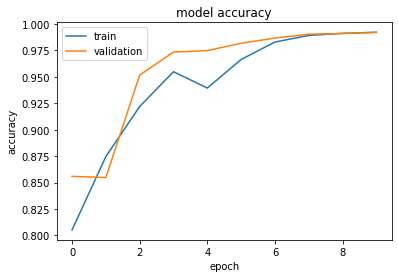

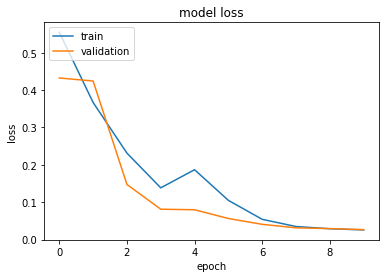

In [65]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['Acc'])
plt.plot(history.history['val_Acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [76]:
def model2():
    name="seq"
    dropout_rate=0.2
    learning_rate=0.001
    sequnce=Input([None],name="sequnce")

    Conv_layer = Conv1D(128, 3, activation='relu')
    
    EMB_layer=Embedding(input_dim=len(voc_set)+1,output_dim=256,name="emb_layer")
    

    LSTM_layer_2=LSTM(units=256,name="lstm_2",return_sequences=False)
    BIDIR_layer_2=Bidirectional(LSTM_layer_2,name="bidirectional_2")
    
    Dens_layer_1=Dense(units=1024,activation=relu,kernel_regularizer=None,bias_regularizer=None,name=name+"_dense_layer_1")
    Dens_layer_2=Dense(units=512,activation=relu,kernel_regularizer=None,bias_regularizer=None,name=name+"_dense_layer_2")
    
    output=Dense(units=number_of_class,activation=softmax,kernel_regularizer=None,bias_regularizer=None,name=name+"_dense_layer_output")
    
    dropout_1=Dropout(dropout_rate)
    
    
    emb_layer=EMB_layer(sequnce)
    conv_layer = Conv_layer(emb_layer)
    logits=output(Dens_layer_2(dropout_1(Dens_layer_1(BIDIR_layer_2(conv_layer)))))

    
    model=tf.keras.Model(inputs={"sequnce":sequnce, },outputs=logits) 
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="Acc")]) 
    model.summary()
    return model 
    

In [75]:
NewModel = model2()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequnce (InputLayer)         [(None, None)]            0         
_________________________________________________________________
emb_layer (Embedding)        (None, None, 256)         6144      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 128)         98432     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               788480    
_________________________________________________________________
seq_dense_layer_1 (Dense)    (None, 1024)              525312    
_________________________________________________________________
dropout_17 (Dropout)         (None, 1024)              0         
_________________________________________________________________
seq_dense_layer_2 (Dense)    (None, 512)              

In [ ]:
history2 = NewModel.fit(train_dl,
                    validation_data=val_dl,
                    epochs=10,
                    verbose=1,
                    validation_steps=val_steps,
                    steps_per_epoch=train_steps,
                     callbacks = [earlyStopping]
                   )

Epoch 1/10
800/800 [==============================] - 614s 767ms/step - loss: 0.6417 - Acc: 0.7741 - val_loss: 0.3723 - val_Acc: 0.8749
Epoch 2/10
779/800 [============================>.] - ETA: 15s - loss: 0.3182 - Acc: 0.8920

In [66]:
def encode_test(text_tensor):
    encoded_text = [ voc_set_map[e] for e in list(text_tensor.numpy().decode())]
    return (encoded_text)
def encode_map_fn_test(text):
    # py_func doesn't set the shape of the returned tensors.
    encoded_text = tf.py_function(encode_test, 
                                       inp=[text], 
                                       Tout=tf.int64)
    encoded_text.set_shape([None])

    
    return (encoded_text)

def get_test_data_loader(file,batch_size):
    data_set=tf.data.TextLineDataset(file)
    data_set=data_set.map(encode_map_fn_test,tf.data.experimental.AUTOTUNE)
    data_set=data_set.padded_batch(batch_size)
    data_set = data_set.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data_set

In [67]:
test=pd.read_csv("/content/UmojaHackTun/test.csv")
test["target"]=0
test_dl=get_data_loader_test("/content/test.txt",512,test)
test_pred=model.predict(test_dl,verbose=True)

222/222 [==============================] - 55s 247ms/step


In [70]:
sub=test[["ID"]].copy()
for i in range(number_of_class):
    sub["target_{}".format(i)]=test_pred[:,i]

In [71]:
sub.head()

,ID,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7
0,ID_test_0,3.478304e-13,9.449766e-09,1.000000,9.277314e-10,1.682552e-11,2.643210e-12,6.677446e-10,1.261195e-15
1,ID_test_1,1.921320e-13,3.641341e-09,1.000000,2.703026e-10,1.163852e-12,1.972484e-13,2.554287e-10,2.607571e-16
2,ID_test_2,2.157307e-11,8.685961e-07,0.999999,8.994353e-08,3.462171e-09,2.789072e-10,5.285719e-09,3.684607e-15
3,ID_test_3,7.473059e-12,8.954356e-08,1.000000,1.910514e-09,6.747767e-12,2.716855e-12,3.041101e-09,2.417511e-14
4,ID_test_4,2.245491e-04,9.905613e-01,0.002935,5.049242e-03,1.095221e-06,9.829196e-04,1.325198e-05,2.330250e-04


In [72]:
sub.to_csv("Beginingin.csv",index=False)

In [73]:
sub.shape

(113618, 9)